In [26]:
"""
Notebook Modeling - Détection de Fraude par Carte Bancaire
Master 2 Ingénierie des Données et Évaluation Économétrique
Phase 3: Entraînement et Évaluation des Modèles
"""

# ============================================================================
# 1. IMPORTATION DES BIBLIOTHÈQUES
# ============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import time
from collections import defaultdict

# Modèles
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, IsolationForest
!pip install xgboost

from xgboost import XGBClassifier

# Validation et métriques
from sklearn.model_selection import StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.metrics import (
    classification_report, confusion_matrix, 
    roc_auc_score, roc_curve, precision_recall_curve, 
    average_precision_score, f1_score, recall_score, precision_score,
    matthews_corrcoef
)

import warnings
warnings.filterwarnings('ignore')

# Configuration
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (14, 6)

print(" Bibliothèques importées avec succès")
print("\n" + "="*80 + "\n")

In [27]:
# ============================================================================
# 2. CHARGEMENT DES DONNÉES PRÉTRAITÉES
# ============================================================================

print(" CHARGEMENT DES DONNÉES PRÉTRAITÉES")
print("="*80)

# Charger le test set (commun à tous)
X_test = joblib.load('data/processed/X_test.pkl')
y_test = joblib.load('data/processed/y_test.pkl')

print(f"\n Test set chargé: {X_test.shape[0]:,} samples")
print(f"   • Légitimes: {(y_test == 0).sum():,}")
print(f"   • Fraudes: {(y_test == 1).sum():,}")

# Charger les différentes versions du train set
train_versions = ['original', 'smote', 'undersampling', 'smote_tomek']
train_data = {}

for version in train_versions:
    X_train = joblib.load(f'data/processed/X_train_{version}.pkl')
    y_train = joblib.load(f'data/processed/y_train_{version}.pkl')
    train_data[version] = (X_train, y_train)
    print(f" Train {version:<15} chargé: {X_train.shape[0]:,} samples")

print("\n" + "="*80 + "\n")


 CHARGEMENT DES DONNÉES PRÉTRAITÉES

 Test set chargé: 56,962 samples
   • Légitimes: 56,864
   • Fraudes: 98
 Train original        chargé: 227,845 samples
 Train smote           chargé: 454,902 samples
 Train undersampling   chargé: 788 samples
 Train smote_tomek     chargé: 454,902 samples




In [28]:
# ============================================================================
# 3. DÉFINITION DES FONCTIONS D'ÉVALUATION
# ============================================================================

print("DÉFINITION DES FONCTIONS D'ÉVALUATION")
print("="*80 + "\n")

def evaluate_model(y_true, y_pred, y_pred_proba=None, model_name="Model"):
    """Évaluation complète d'un modèle"""
    
    results = {
        'model': model_name,
        'accuracy': np.mean(y_pred == y_true),
        'precision': precision_score(y_true, y_pred),
        'recall': recall_score(y_true, y_pred),
        'f1': f1_score(y_true, y_pred),
        'mcc': matthews_corrcoef(y_true, y_pred)
    }
    
    if y_pred_proba is not None:
        results['roc_auc'] = roc_auc_score(y_true, y_pred_proba)
        results['pr_auc'] = average_precision_score(y_true, y_pred_proba)
    
    return results

def plot_confusion_matrix(y_true, y_pred, title="Confusion Matrix"):
    """Afficher une matrice de confusion stylisée"""
    cm = confusion_matrix(y_true, y_pred)
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True,
                xticklabels=['Légitime', 'Fraude'],
                yticklabels=['Légitime', 'Fraude'])
    plt.title(title, fontsize=14, fontweight='bold')
    plt.ylabel('Vraie Classe', fontsize=12)
    plt.xlabel('Classe Prédite', fontsize=12)
    
    # Ajouter les pourcentages
    total = cm.sum()
    for i in range(2):
        for j in range(2):
            pct = (cm[i, j] / total) * 100
            plt.text(j+0.5, i+0.7, f'({pct:.2f}%)', 
                    ha='center', va='center', fontsize=10, color='gray')
    
    plt.tight_layout()
    return cm

def plot_roc_pr_curves(models_results):
    """Tracer les courbes ROC et Precision-Recall pour tous les modèles"""
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Courbe ROC
    for model_name, (y_pred_proba, _) in models_results.items():
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        auc_score = roc_auc_score(y_test, y_pred_proba)
        axes[0].plot(fpr, tpr, label=f'{model_name} (AUC={auc_score:.3f})', linewidth=2)
    
    axes[0].plot([0, 1], [0, 1], 'k--', label='Aléatoire', linewidth=1)
    axes[0].set_xlabel('Taux de Faux Positifs (FPR)', fontsize=12, fontweight='bold')
    axes[0].set_ylabel('Taux de Vrais Positifs (TPR)', fontsize=12, fontweight='bold')
    axes[0].set_title('Courbe ROC', fontsize=14, fontweight='bold')
    axes[0].legend(loc='lower right')
    axes[0].grid(alpha=0.3)
    
    # Courbe Precision-Recall
    for model_name, (y_pred_proba, _) in models_results.items():
        precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
        pr_auc = average_precision_score(y_test, y_pred_proba)
        axes[1].plot(recall, precision, label=f'{model_name} (AUC={pr_auc:.3f})', linewidth=2)
    
    # Baseline (proportion de fraudes)
    baseline = y_test.sum() / len(y_test)
    axes[1].axhline(y=baseline, color='k', linestyle='--', 
                    label=f'Baseline ({baseline:.3f})', linewidth=1)
    
    axes[1].set_xlabel('Recall', fontsize=12, fontweight='bold')
    axes[1].set_ylabel('Precision', fontsize=12, fontweight='bold')
    axes[1].set_title('Courbe Precision-Recall', fontsize=14, fontweight='bold')
    axes[1].legend(loc='best')
    axes[1].grid(alpha=0.3)
    
    plt.tight_layout()
    return fig

print(" Fonctions d'évaluation définies")
print("\n" + "="*80 + "\n")


DÉFINITION DES FONCTIONS D'ÉVALUATION

 Fonctions d'évaluation définies




 MODÈLE 1: RÉGRESSION LOGISTIQUE (BASELINE)

 Entraînement sur données originales avec class_weight='balanced'...

  Temps d'entraînement: 6.79s

 Résultats:
   • Accuracy:  0.9727
   • Precision: 0.0544
   • Recall:    0.9082
   • F1-Score:  0.1026
   • ROC-AUC:   0.9763
   • PR-AUC:    0.7232
   • MCC:       0.2185


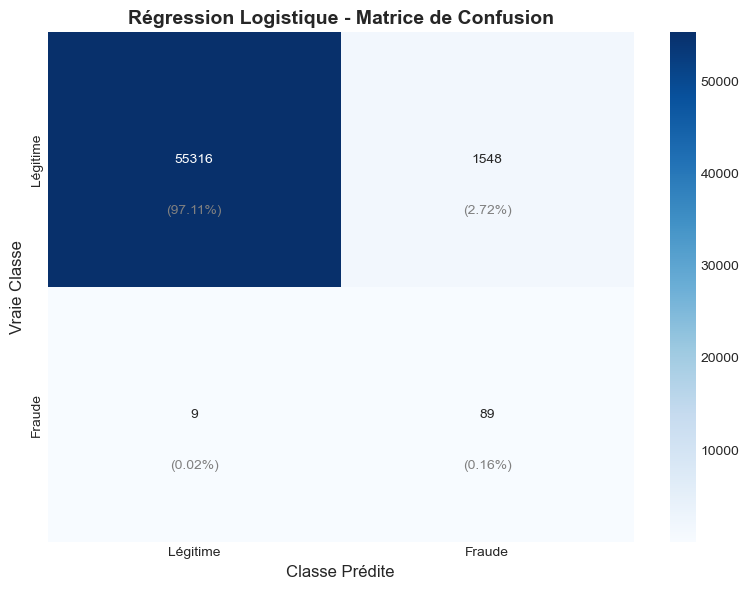

In [29]:
# ============================================================================
# 4. MODÈLE BASELINE: RÉGRESSION LOGISTIQUE
# ============================================================================

print(" MODÈLE 1: RÉGRESSION LOGISTIQUE (BASELINE)")
print("="*80)

# Tester sur données originales avec class_weight
X_train_orig, y_train_orig = train_data['original']

print("\n Entraînement sur données originales avec class_weight='balanced'...")
start_time = time.time()

lr_model = LogisticRegression(
    class_weight='balanced',
    max_iter=1000,
    random_state=42,
    n_jobs=-1
)

lr_model.fit(X_train_orig, y_train_orig)
train_time = time.time() - start_time

# Prédictions
y_pred_lr = lr_model.predict(X_test)
y_pred_proba_lr = lr_model.predict_proba(X_test)[:, 1]

# Évaluation
results_lr = evaluate_model(y_test, y_pred_lr, y_pred_proba_lr, "Logistic Regression")

print(f"\n  Temps d'entraînement: {train_time:.2f}s")
print(f"\n Résultats:")
print(f"   • Accuracy:  {results_lr['accuracy']:.4f}")
print(f"   • Precision: {results_lr['precision']:.4f}")
print(f"   • Recall:    {results_lr['recall']:.4f}")
print(f"   • F1-Score:  {results_lr['f1']:.4f}")
print(f"   • ROC-AUC:   {results_lr['roc_auc']:.4f}")
print(f"   • PR-AUC:    {results_lr['pr_auc']:.4f}")
print(f"   • MCC:       {results_lr['mcc']:.4f}")

# Matrice de confusion
cm_lr = plot_confusion_matrix(y_test, y_pred_lr, "Régression Logistique - Matrice de Confusion")
plt.savefig('reports/figures/09_lr_confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n" + "="*80 + "\n")

 MODÈLE 2: RANDOM FOREST

 Entraînement sur données SMOTE...

  Temps d'entraînement: 100.29s

 Résultats:
   • Accuracy:  0.9992
   • Precision: 0.7500
   • Recall:    0.8265
   • F1-Score:  0.7864
   • ROC-AUC:   0.9774
   • PR-AUC:    0.8576
   • MCC:       0.7870


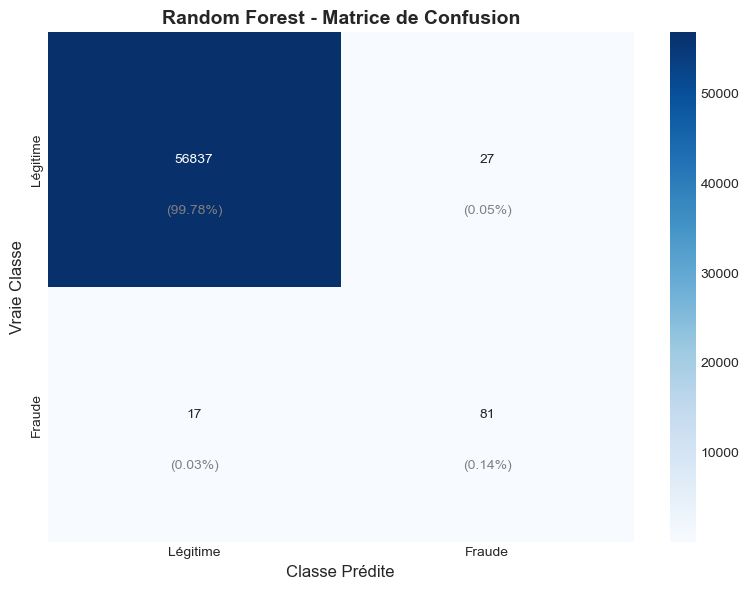


 Top 10 Features Importantes:
feature  importance
    V14    0.150465
    V12    0.124183
    V10    0.105942
     V4    0.099341
    V17    0.079781
    V11    0.075753
    V16    0.049264
     V3    0.043844
     V7    0.043000
    V21    0.022230


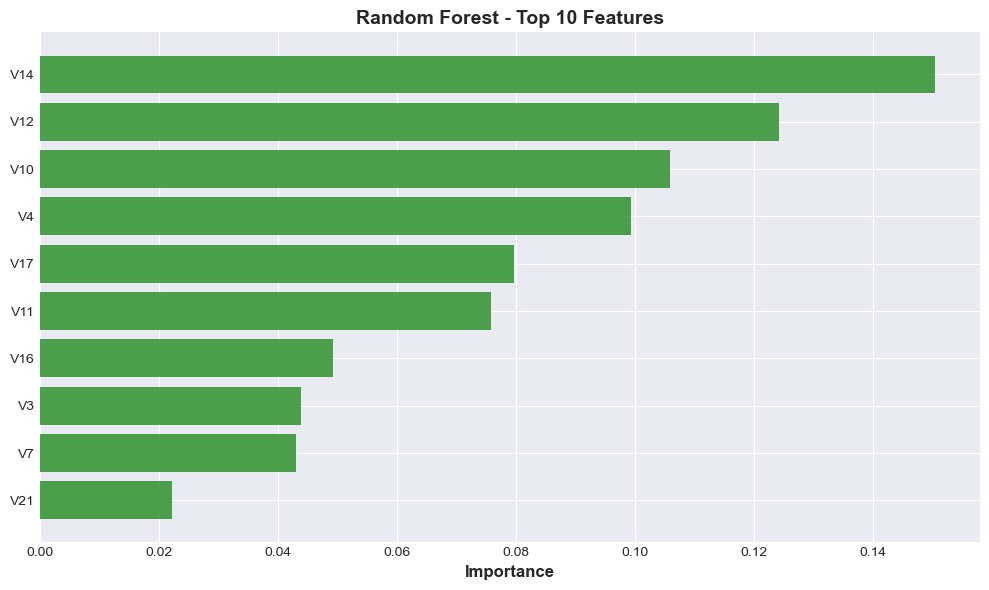

In [30]:
# ============================================================================
# 5. RANDOM FOREST
# ============================================================================

print(" MODÈLE 2: RANDOM FOREST")
print("="*80)

# Tester avec SMOTE
X_train_smote, y_train_smote = train_data['smote']

print("\n Entraînement sur données SMOTE...")
start_time = time.time()

rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=20,
    min_samples_split=10,
    min_samples_leaf=4,
    random_state=42,
    n_jobs=-1,
    verbose=0
)

rf_model.fit(X_train_smote, y_train_smote)
train_time = time.time() - start_time

# Prédictions
y_pred_rf = rf_model.predict(X_test)
y_pred_proba_rf = rf_model.predict_proba(X_test)[:, 1]

# Évaluation
results_rf = evaluate_model(y_test, y_pred_rf, y_pred_proba_rf, "Random Forest")

print(f"\n  Temps d'entraînement: {train_time:.2f}s")
print(f"\n Résultats:")
print(f"   • Accuracy:  {results_rf['accuracy']:.4f}")
print(f"   • Precision: {results_rf['precision']:.4f}")
print(f"   • Recall:    {results_rf['recall']:.4f}")
print(f"   • F1-Score:  {results_rf['f1']:.4f}")
print(f"   • ROC-AUC:   {results_rf['roc_auc']:.4f}")
print(f"   • PR-AUC:    {results_rf['pr_auc']:.4f}")
print(f"   • MCC:       {results_rf['mcc']:.4f}")

# Matrice de confusion
cm_rf = plot_confusion_matrix(y_test, y_pred_rf, "Random Forest - Matrice de Confusion")
plt.savefig('reports/figures/10_rf_confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

# Feature importance
print("\n Top 10 Features Importantes:")
feature_importance = pd.DataFrame({
    'feature': X_test.columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False).head(10)

print(feature_importance.to_string(index=False))

plt.figure(figsize=(10, 6))
plt.barh(range(10), feature_importance['importance'].values, color='forestgreen', alpha=0.8)
plt.yticks(range(10), feature_importance['feature'].values)
plt.xlabel('Importance', fontsize=12, fontweight='bold')
plt.title('Random Forest - Top 10 Features', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig('reports/figures/11_rf_feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n" + "="*80 + "\n")

 MODÈLE 3: XGBOOST

 scale_pos_weight calculé: 577.29

 Entraînement sur données originales avec scale_pos_weight...

 Temps d'entraînement: 1.81s

 Résultats:
   • Accuracy:  0.9992
   • Precision: 0.7155
   • Recall:    0.8469
   • F1-Score:  0.7757
   • ROC-AUC:   0.9824
   • PR-AUC:    0.8627
   • MCC:       0.7780


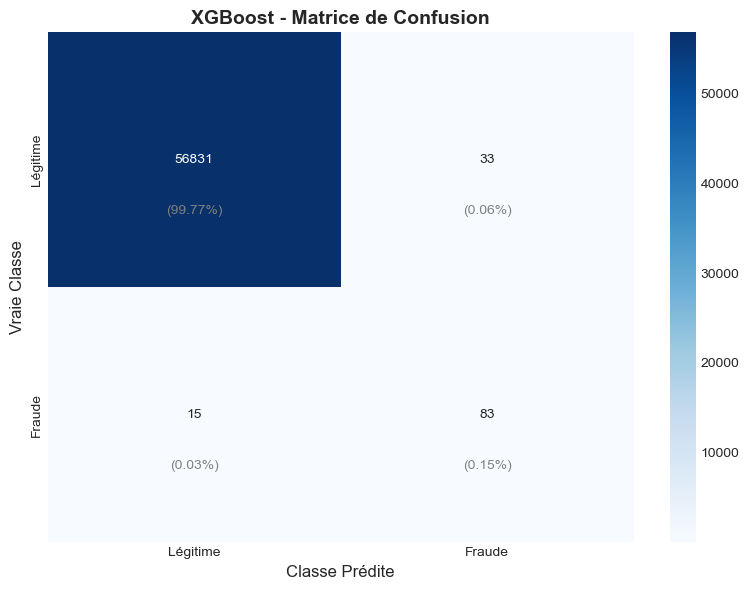


 Top 10 Features Importantes:
feature  importance
    V14    0.382151
    V10    0.082469
     V4    0.071635
    V20    0.040705
    V12    0.026935
     V8    0.024053
     V7    0.023447
 Amount    0.022765
    V17    0.019790
    V26    0.018862


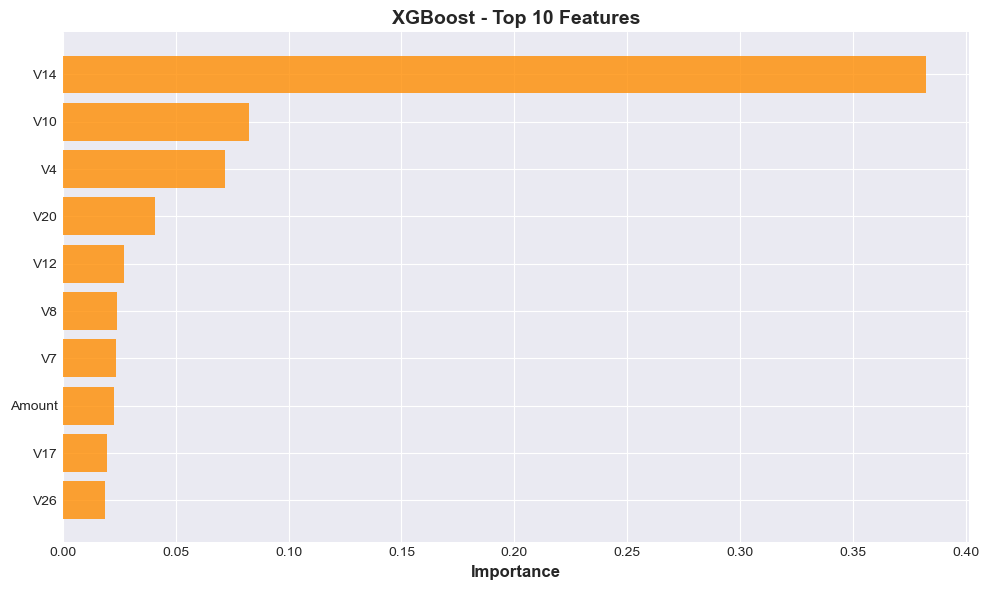

In [31]:
# ============================================================================
# 6. XGBOOST
# ============================================================================

print(" MODÈLE 3: XGBOOST")
print("="*80)

# Calculer scale_pos_weight pour données originales
scale_pos_weight = (y_train_orig == 0).sum() / (y_train_orig == 1).sum()

print(f"\n scale_pos_weight calculé: {scale_pos_weight:.2f}")
print("\n Entraînement sur données originales avec scale_pos_weight...")
start_time = time.time()

xgb_model = XGBClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    scale_pos_weight=scale_pos_weight,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1,
    eval_metric='logloss'
)

xgb_model.fit(X_train_orig, y_train_orig)
train_time = time.time() - start_time

# Prédictions
y_pred_xgb = xgb_model.predict(X_test)
y_pred_proba_xgb = xgb_model.predict_proba(X_test)[:, 1]

# Évaluation
results_xgb = evaluate_model(y_test, y_pred_xgb, y_pred_proba_xgb, "XGBoost")

print(f"\n Temps d'entraînement: {train_time:.2f}s")
print(f"\n Résultats:")
print(f"   • Accuracy:  {results_xgb['accuracy']:.4f}")
print(f"   • Precision: {results_xgb['precision']:.4f}")
print(f"   • Recall:    {results_xgb['recall']:.4f}")
print(f"   • F1-Score:  {results_xgb['f1']:.4f}")
print(f"   • ROC-AUC:   {results_xgb['roc_auc']:.4f}")
print(f"   • PR-AUC:    {results_xgb['pr_auc']:.4f}")
print(f"   • MCC:       {results_xgb['mcc']:.4f}")

# Matrice de confusion
cm_xgb = plot_confusion_matrix(y_test, y_pred_xgb, "XGBoost - Matrice de Confusion")
plt.savefig('reports/figures/12_xgb_confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

# Feature importance
print("\n Top 10 Features Importantes:")
xgb_importance = pd.DataFrame({
    'feature': X_test.columns,
    'importance': xgb_model.feature_importances_
}).sort_values('importance', ascending=False).head(10)

print(xgb_importance.to_string(index=False))

plt.figure(figsize=(10, 6))
plt.barh(range(10), xgb_importance['importance'].values, color='darkorange', alpha=0.8)
plt.yticks(range(10), xgb_importance['feature'].values)
plt.xlabel('Importance', fontsize=12, fontweight='bold')
plt.title('XGBoost - Top 10 Features', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig('reports/figures/13_xgb_feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n" + "="*80 + "\n")

 MODÈLE 4: ISOLATION FOREST

 Entraînement sur données originales (détection d'anomalies)...

  Temps d'entraînement: 1.68s

 Résultats:
   • Accuracy:  0.9974
   • Precision: 0.2661
   • Recall:    0.2959
   • F1-Score:  0.2802
   • ROC-AUC:   0.9528
   • PR-AUC:    0.1736
   • MCC:       0.2793


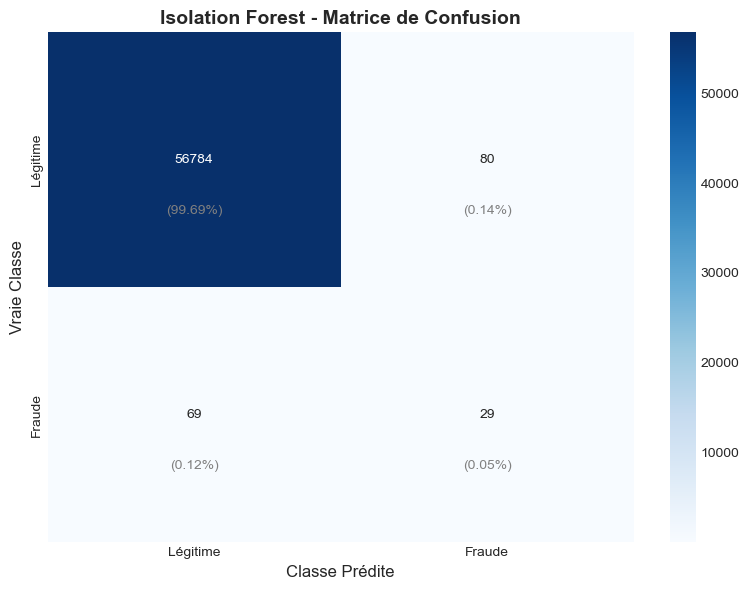

In [32]:

# ============================================================================
# 7. ISOLATION FOREST (Détection d'Anomalies)
# ============================================================================

print(" MODÈLE 4: ISOLATION FOREST")
print("="*80)

print("\n Entraînement sur données originales (détection d'anomalies)...")
start_time = time.time()

# Contamination = proportion de fraudes dans le dataset
contamination = y_train_orig.sum() / len(y_train_orig)

iso_forest = IsolationForest(
    n_estimators=100,
    contamination=contamination,
    random_state=42,
    n_jobs=-1
)

iso_forest.fit(X_train_orig)
train_time = time.time() - start_time

# Prédictions (-1 = anomalie/fraude, 1 = normal/légitime)
y_pred_iso_raw = iso_forest.predict(X_test)
y_pred_iso = np.where(y_pred_iso_raw == -1, 1, 0)  # Convertir en 0/1

# Scores d'anomalie
y_scores_iso = -iso_forest.score_samples(X_test)  # Plus haut = plus anormal

# Évaluation (pas de probabilités pour Isolation Forest)
results_iso = evaluate_model(y_test, y_pred_iso, y_scores_iso, "Isolation Forest")

print(f"\n  Temps d'entraînement: {train_time:.2f}s")
print(f"\n Résultats:")
print(f"   • Accuracy:  {results_iso['accuracy']:.4f}")
print(f"   • Precision: {results_iso['precision']:.4f}")
print(f"   • Recall:    {results_iso['recall']:.4f}")
print(f"   • F1-Score:  {results_iso['f1']:.4f}")
print(f"   • ROC-AUC:   {results_iso['roc_auc']:.4f}")
print(f"   • PR-AUC:    {results_iso['pr_auc']:.4f}")
print(f"   • MCC:       {results_iso['mcc']:.4f}")

# Matrice de confusion
cm_iso = plot_confusion_matrix(y_test, y_pred_iso, "Isolation Forest - Matrice de Confusion")
plt.savefig('reports/figures/14_iso_confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n" + "="*80 + "\n")

 COMPARAISON DES MODÈLES

 Tableau Comparatif:
                     accuracy  precision    recall        f1       mcc   roc_auc    pr_auc
model                                                                                     
Logistic Regression  0.972666   0.054368  0.908163  0.102594  0.218521  0.976339  0.723188
Random Forest        0.999228   0.750000  0.826531  0.786408  0.786953  0.977409  0.857620
XGBoost              0.999157   0.715517  0.846939  0.775701  0.778049  0.982433  0.862669
Isolation Forest     0.997384   0.266055  0.295918  0.280193  0.279283  0.952793  0.173633


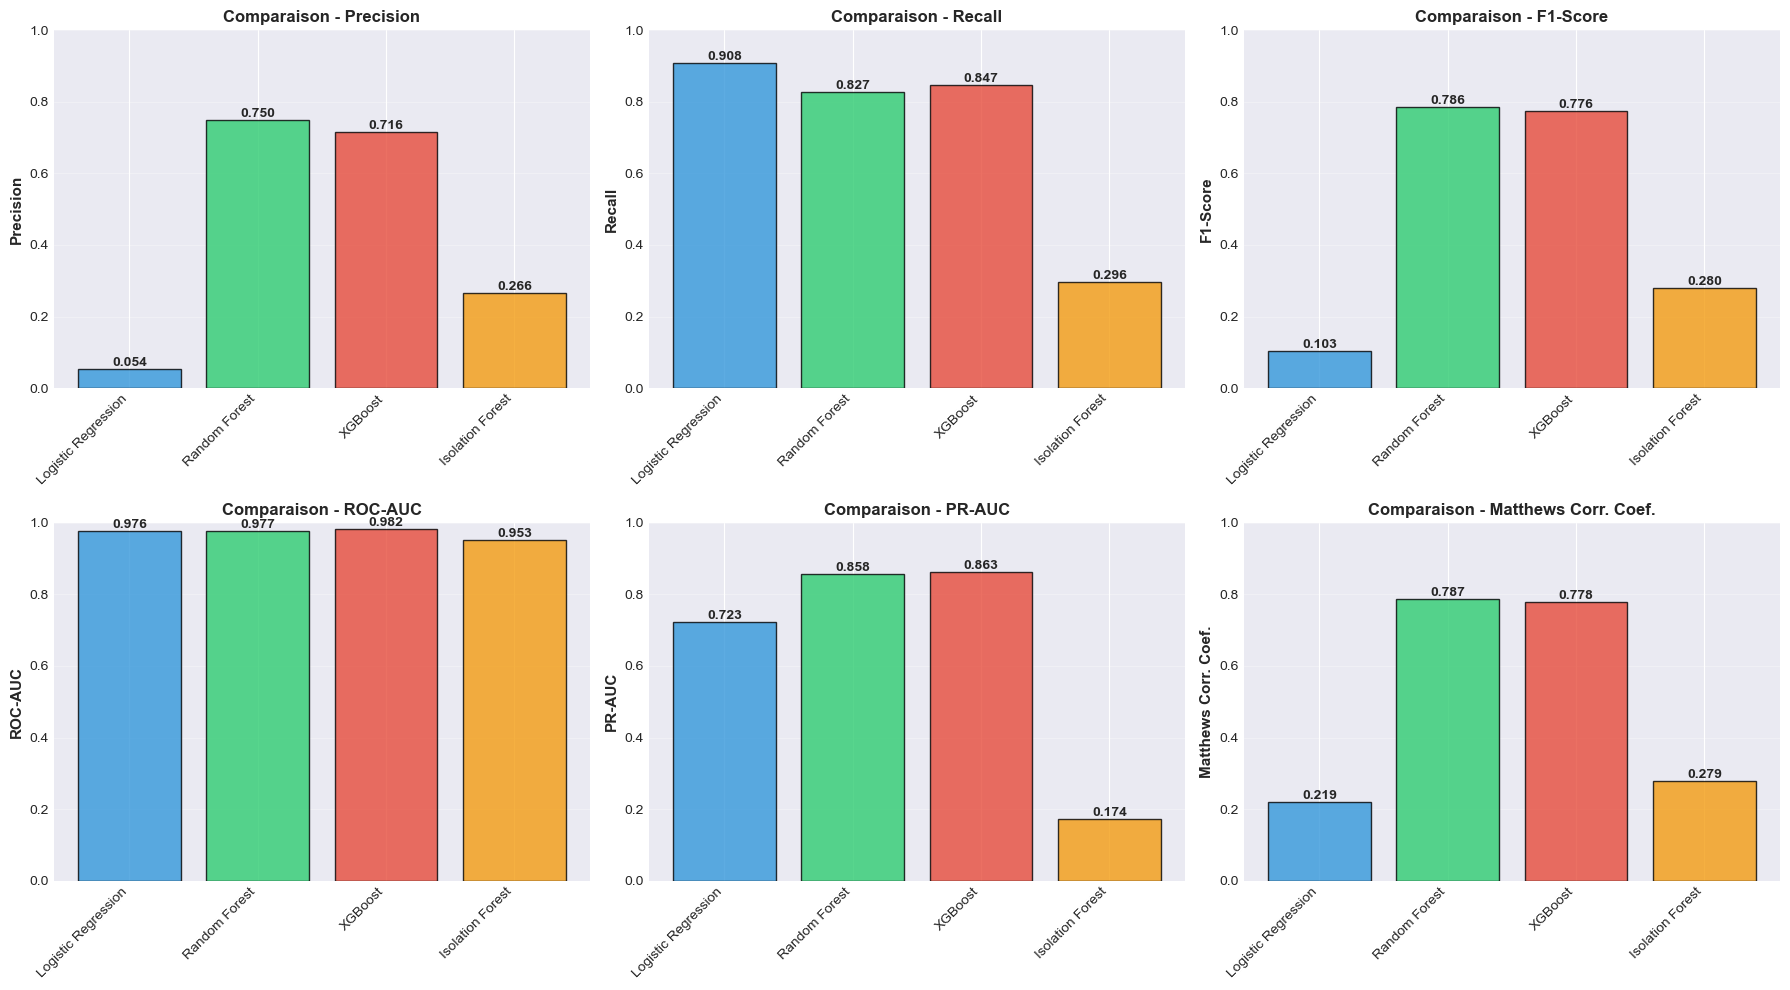

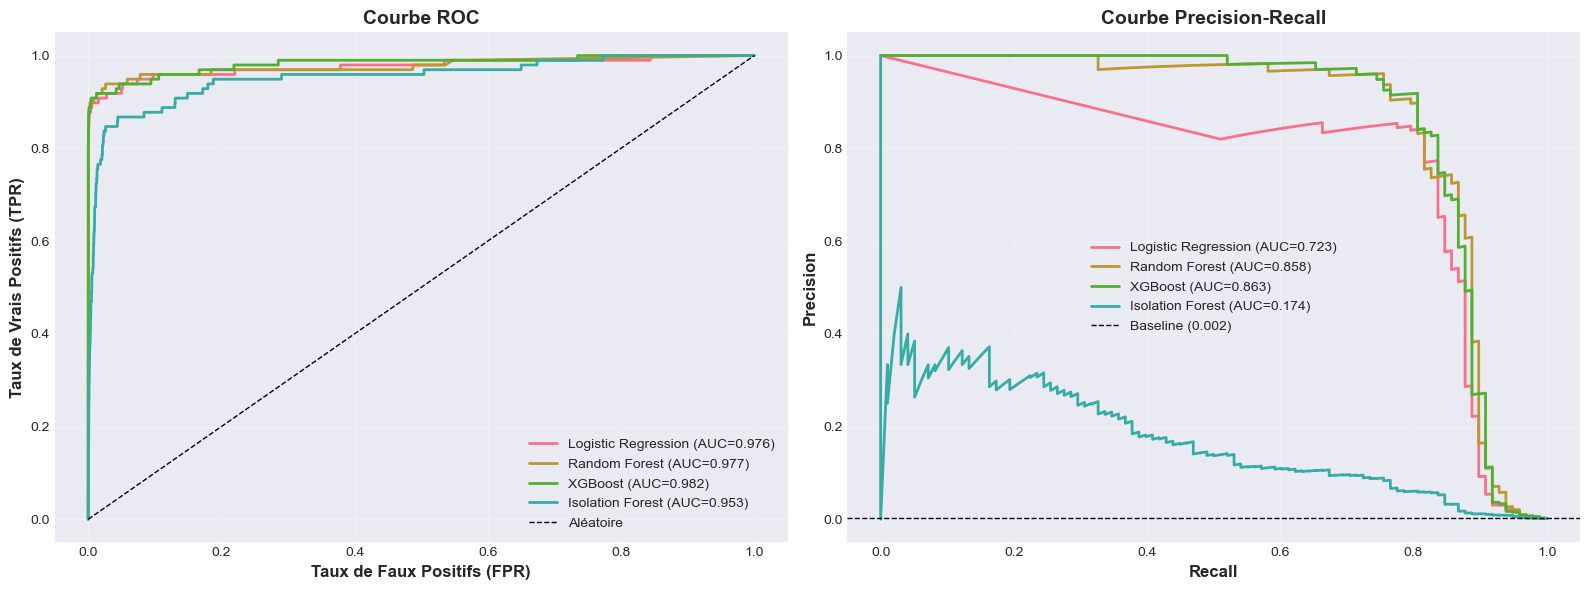

In [33]:

# ============================================================================
# 8. COMPARAISON DES MODÈLES
# ============================================================================

print(" COMPARAISON DES MODÈLES")
print("="*80)

# Créer un DataFrame de comparaison
comparison_df = pd.DataFrame([results_lr, results_rf, results_xgb, results_iso])
comparison_df = comparison_df.set_index('model')

print("\n Tableau Comparatif:")
print(comparison_df.to_string())

# Visualisation comparative
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

metrics = ['precision', 'recall', 'f1', 'roc_auc', 'pr_auc', 'mcc']
titles = ['Precision', 'Recall', 'F1-Score', 'ROC-AUC', 'PR-AUC', 'Matthews Corr. Coef.']

for idx, (metric, title) in enumerate(zip(metrics, titles)):
    ax = axes[idx // 3, idx % 3]
    values = comparison_df[metric].values
    colors = ['#3498db', '#2ecc71', '#e74c3c', '#f39c12']
    bars = ax.bar(range(len(comparison_df)), values, color=colors, alpha=0.8, edgecolor='black')
    ax.set_xticks(range(len(comparison_df)))
    ax.set_xticklabels(comparison_df.index, rotation=45, ha='right')
    ax.set_ylabel(title, fontsize=11, fontweight='bold')
    ax.set_title(f'Comparaison - {title}', fontsize=12, fontweight='bold')
    ax.set_ylim([0, 1])
    ax.grid(alpha=0.3, axis='y')
    
    # Ajouter les valeurs sur les barres
    for bar, val in zip(bars, values):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{val:.3f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.savefig('reports/figures/15_models_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# Courbes ROC et PR
models_results = {
    'Logistic Regression': (y_pred_proba_lr, y_pred_lr),
    'Random Forest': (y_pred_proba_rf, y_pred_rf),
    'XGBoost': (y_pred_proba_xgb, y_pred_xgb),
    'Isolation Forest': (y_scores_iso, y_pred_iso)
}

fig = plot_roc_pr_curves(models_results)
plt.savefig('reports/figures/16_roc_pr_curves.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n" + "="*80 + "\n")

 ANALYSE BUSINESS DES COÛTS

 Hypothèses de coût:
   • Fraude non détectée (FN): 100€
   • Faux positif (FP): 2€

 Coûts par modèle:

   Logistic Regression  :      3,996€  (FN=9, FP=1548)
   Random Forest        :      1,754€  (FN=17, FP=27)
   XGBoost              :      1,566€  (FN=15, FP=33)
   Isolation Forest     :      7,060€  (FN=69, FP=80)


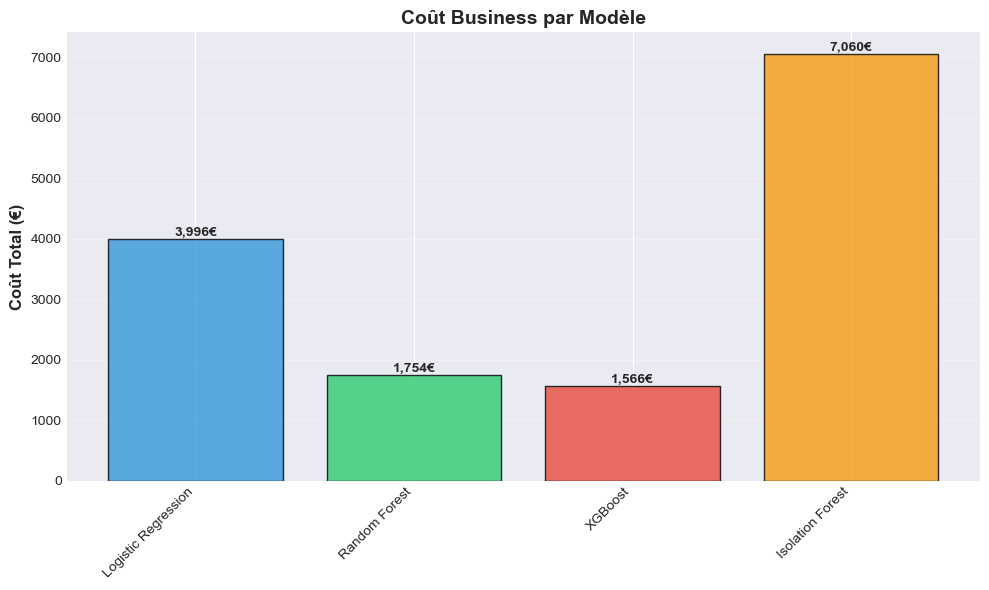


 MEILLEUR MODÈLE (coût le plus bas): XGBoost
   Économie potentielle: 5,494€




In [34]:

# ============================================================================
# 9. ANALYSE BUSINESS DES COÛTS
# ============================================================================

print(" ANALYSE BUSINESS DES COÛTS")
print("="*80)

# Hypothèses business
COST_FALSE_NEGATIVE = 100  # Coût d'une fraude non détectée (100€)
COST_FALSE_POSITIVE = 2    # Coût d'un faux positif (vérification manuelle, 2€)

def calculate_business_cost(cm):
    """Calculer le coût business d'une matrice de confusion"""
    tn, fp, fn, tp = cm.ravel()
    cost = (fn * COST_FALSE_NEGATIVE) + (fp * COST_FALSE_POSITIVE)
    return cost, fn, fp

print(f"\n Hypothèses de coût:")
print(f"   • Fraude non détectée (FN): {COST_FALSE_NEGATIVE}€")
print(f"   • Faux positif (FP): {COST_FALSE_POSITIVE}€")

print(f"\n Coûts par modèle:\n")

models_costs = {}
for model_name, cm in [
    ('Logistic Regression', cm_lr),
    ('Random Forest', cm_rf),
    ('XGBoost', cm_xgb),
    ('Isolation Forest', cm_iso)
]:
    cost, fn, fp = calculate_business_cost(cm)
    models_costs[model_name] = cost
    print(f"   {model_name:<20} : {cost:>10,}€  (FN={fn}, FP={fp})")

# Visualisation des coûts
plt.figure(figsize=(10, 6))
colors = ['#3498db', '#2ecc71', '#e74c3c', '#f39c12']
bars = plt.bar(range(len(models_costs)), list(models_costs.values()), 
               color=colors, alpha=0.8, edgecolor='black')
plt.xticks(range(len(models_costs)), list(models_costs.keys()), rotation=45, ha='right')
plt.ylabel('Coût Total (€)', fontsize=12, fontweight='bold')
plt.title('Coût Business par Modèle', fontsize=14, fontweight='bold')
plt.grid(alpha=0.3, axis='y')

for bar, cost in zip(bars, models_costs.values()):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{cost:,.0f}€', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.savefig('reports/figures/17_business_cost_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

best_model = min(models_costs, key=models_costs.get)
print(f"\n MEILLEUR MODÈLE (coût le plus bas): {best_model}")
print(f"   Économie potentielle: {max(models_costs.values()) - min(models_costs.values()):,.0f}€")

print("\n" + "="*80 + "\n")

In [35]:

# ============================================================================
# 10. SAUVEGARDE DES MODÈLES
# ============================================================================

print(" SAUVEGARDE DES MODÈLES")
print("="*80)

# Sauvegarder tous les modèles
models_to_save = {
    'logistic_regression': lr_model,
    'random_forest': rf_model,
    'xgboost': xgb_model,
    'isolation_forest': iso_forest
}

for name, model in models_to_save.items():
    joblib.dump(model, f'models/{name}_model.pkl')
    print(f" {name:<25} sauvegardé")

# Sauvegarder les résultats
comparison_df.to_csv('reports/models_comparison.csv')
print(f"\n Tableau comparatif sauvegardé: reports/models_comparison.csv")

print("\n" + "="*80 + "\n")


 SAUVEGARDE DES MODÈLES
 logistic_regression       sauvegardé
 random_forest             sauvegardé
 xgboost                   sauvegardé
 isolation_forest          sauvegardé

 Tableau comparatif sauvegardé: reports/models_comparison.csv




In [36]:

# ============================================================================
# 11. RECOMMANDATIONS FINALES
# ============================================================================

print(" SYNTHÈSE ET RECOMMANDATIONS")
print("="*80)

# Identifier le meilleur modèle selon différents critères
best_recall = comparison_df['recall'].idxmax()
best_precision = comparison_df['precision'].idxmax()
best_f1 = comparison_df['f1'].idxmax()
best_roc_auc = comparison_df['roc_auc'].idxmax()

summary = f"""
 MODÉLISATION TERMINÉE

 PERFORMANCES:

• Meilleur Recall (capturer les fraudes):     {best_recall}
  → {comparison_df.loc[best_recall, 'recall']:.4f}
  
• Meilleure Precision (limiter faux positifs): {best_precision}
  → {comparison_df.loc[best_precision, 'precision']:.4f}
  
• Meilleur F1-Score (équilibre):               {best_f1}
  → {comparison_df.loc[best_f1, 'f1']:.4f}
  
• Meilleur ROC-AUC (discrimination):           {best_roc_auc}
  → {comparison_df.loc[best_roc_auc, 'roc_auc']:.4f}

 ANALYSE BUSINESS:

• Modèle le plus économique:  {best_model}
  → Coût total: {models_costs[best_model]:,}€

 RECOMMANDATION:

Pour la détection de fraude bancaire, privilégier:
→ {best_recall} si priorité = capturer TOUTES les fraudes (minimiser FN)
→ {best_model} si priorité = optimiser les coûts business

 PROCHAINES ÉTAPES:

1. Hyperparameter Tuning (GridSearch/RandomSearch)
   • Optimiser les paramètres du meilleur modèle
   • Tester plus de combinaisons

2. Ensemble Methods
   • Voting Classifier (combinaison de modèles)
   • Stacking

3. Validation croisée approfondie
   • StratifiedKFold avec 10 folds
   • Vérifier la stabilité des performances

4. Mise en production
   • API REST avec FastAPI
   • Pipeline de prédiction en temps réel
   • Monitoring des performances

 FICHIERS GÉNÉRÉS:

models/
├── logistic_regression_model.pkl
├── random_forest_model.pkl
├── xgboost_model.pkl
└── isolation_forest_model.pkl

reports/
├── models_comparison.csv
└── figures/
    ├── 09-17_*.png (9 graphiques)

 Prochaine étape: 04_evaluation.ipynb (optionnel)
   → Analyse approfondie du meilleur modèle
   → SHAP values pour interprétabilité
   → Optimisation du seuil de décision
"""

print(summary)
print("="*80)
print("\n MODÉLISATION TERMINÉE!")
print("🎉 Projet prêt pour votre GitHub!")
print("\n" + "="*80)

 SYNTHÈSE ET RECOMMANDATIONS

 MODÉLISATION TERMINÉE

 PERFORMANCES:

• Meilleur Recall (capturer les fraudes):     Logistic Regression
  → 0.9082
  
• Meilleure Precision (limiter faux positifs): Random Forest
  → 0.7500
  
• Meilleur F1-Score (équilibre):               Random Forest
  → 0.7864
  
• Meilleur ROC-AUC (discrimination):           XGBoost
  → 0.9824

 ANALYSE BUSINESS:

• Modèle le plus économique:  XGBoost
  → Coût total: 1,566€

 RECOMMANDATION:

Pour la détection de fraude bancaire, privilégier:
→ Logistic Regression si priorité = capturer TOUTES les fraudes (minimiser FN)
→ XGBoost si priorité = optimiser les coûts business

 PROCHAINES ÉTAPES:

1. Hyperparameter Tuning (GridSearch/RandomSearch)
   • Optimiser les paramètres du meilleur modèle
   • Tester plus de combinaisons

2. Ensemble Methods
   • Voting Classifier (combinaison de modèles)
   • Stacking

3. Validation croisée approfondie
   • StratifiedKFold avec 10 folds
   • Vérifier la stabilité des performance